<a href="https://colab.research.google.com/github/MarianoChic09/MSc-AI-taller-de-deep-learning/blob/main/MSc_AI_TDL_Tarea_2_NLP_insincere_questions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
! cp -r "/content/drive/MyDrive/Colab Notebooks/Datasets/insincere_questions/." .
# ! unzip -q insincere_questions.zip
# ! rm insincere_questions.zip
! ls


drive  sample_data  test_set.csv  train_set.csv


In [3]:
import time
import torch
import itertools
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns


# Carga de datos

In [22]:
# Global device config
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
all_train_data = pd.read_csv("train_set.csv")
train, validation = train_test_split(all_train_data,
stratify=all_train_data.target, test_size=0.2)
print(f"{len(train)} Training questions, {len(validation)} Validation questions")

test = pd.read_csv("test_set.csv")


258592 Training questions, 64648 Validation questions


# Análisis exploratorio

In [5]:
# Análisis exploratorio básico de los datasets
datasets = {'Training': train, 'Validation': validation, 'Test': test}


Información básica del dataset Training:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 258592 entries, 223730 to 40375
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   question_text  258592 non-null  object
 1   target         258592 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 5.9+ MB
None

Primeras 5 filas del dataset Training:
                                            question_text  target
223730  What is the condition of Punjab right now? Wha...       0
274166  What American TV shows give representation to ...       0
119047             Why Americans no longer eat Tide Pods?       1
300631  Is the AMD Athlon II X4 760K good enough for P...       0
57679   Are there any anti gay politicians in the U.K....       0


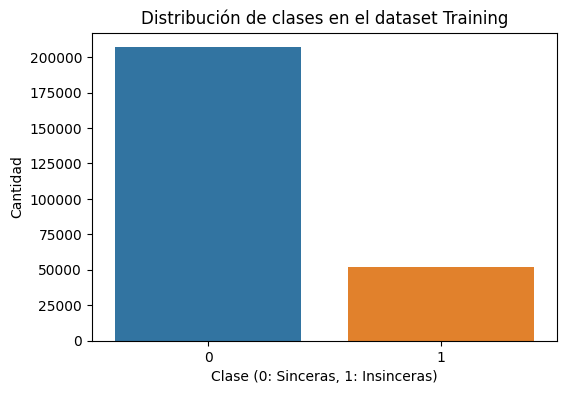

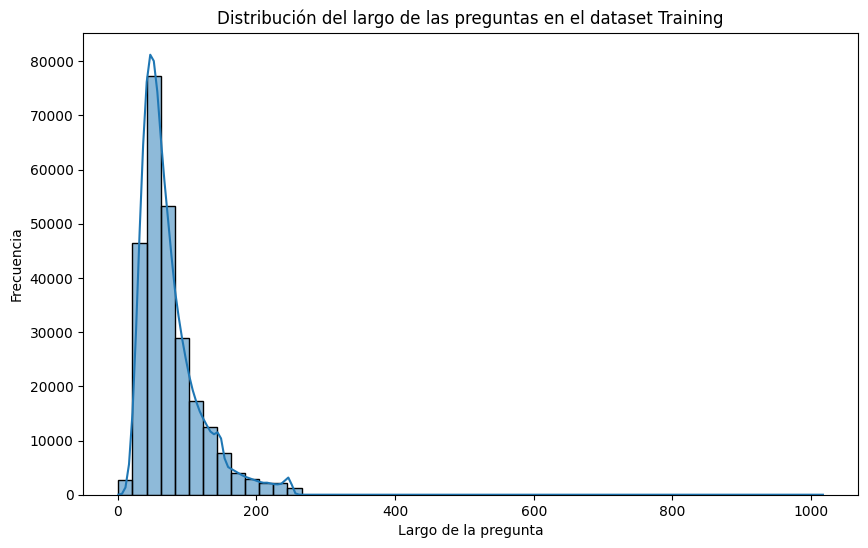

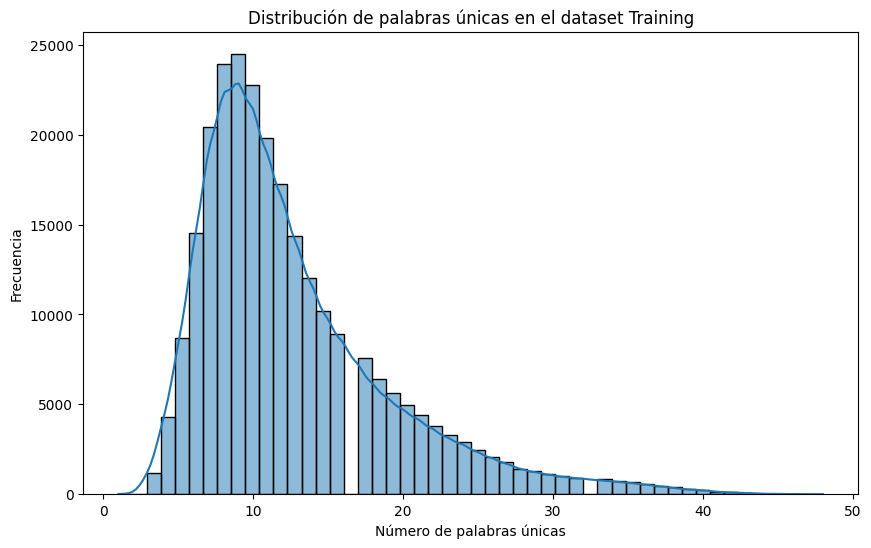


Valores nulos en el dataset Training:
question_text    0
target           0
length           0
unique_words     0
dtype: int64

Información básica del dataset Validation:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 64648 entries, 282623 to 187114
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   question_text  64648 non-null  object
 1   target         64648 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ MB
None

Primeras 5 filas del dataset Validation:
                                            question_text  target
282623         From which books neet questions are asked?       0
127410  How does an atheist find strength to carry on ...       0
8582    If someone offers me a car, and I take it, doe...       0
132253    When will Germany be a home only for Germanity?       1
290818  How hard is it to have a fresh new start at a ...       0


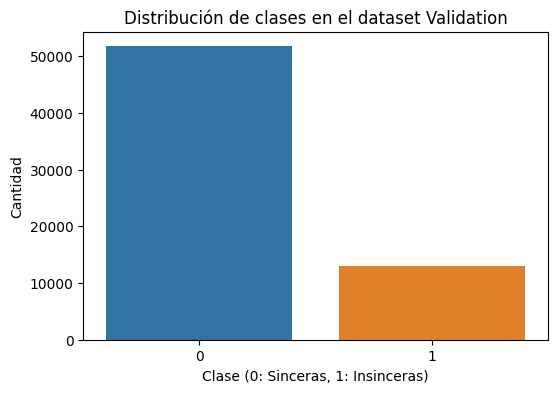

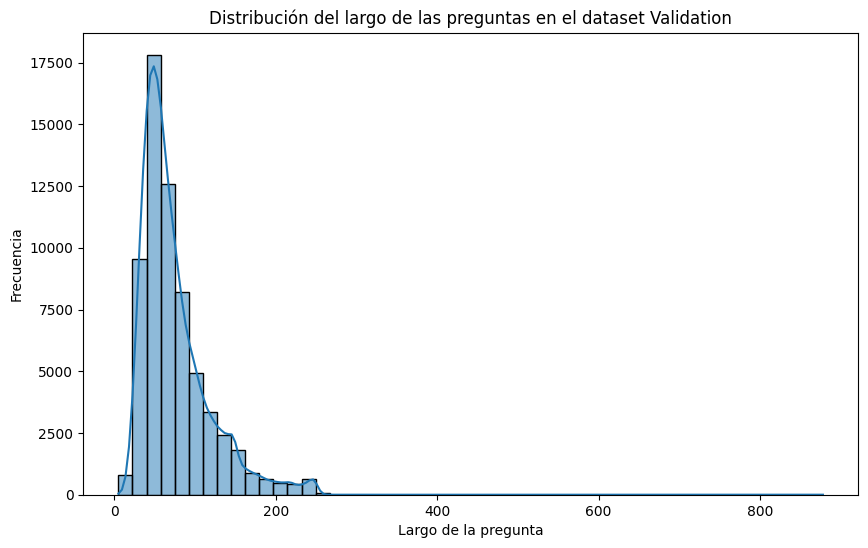

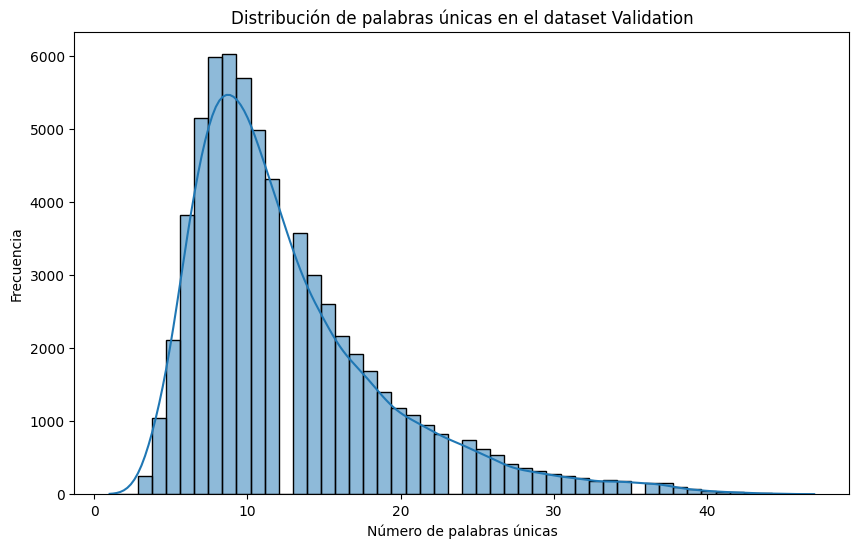


Valores nulos en el dataset Validation:
question_text    0
target           0
length           0
unique_words     0
dtype: int64

Información básica del dataset Test:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80810 entries, 0 to 80809
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   question_text  80810 non-null  object
 1   target         80810 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ MB
None

Primeras 5 filas del dataset Test:
                                       question_text  target
0  Is it weird that I want my future boyfriend to...       0
1               How can I promote my webinar on RPA?       0
2  Why is it Indians in West accept transgenders ...       1
3  How many of these 'Trump achievements' are cor...       0
4  Why did I walk in on my sister fucking my hams...       1


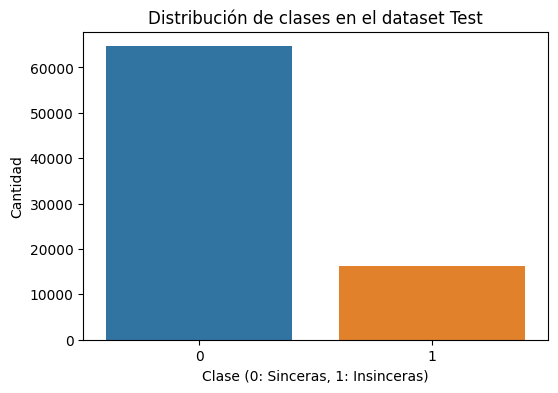

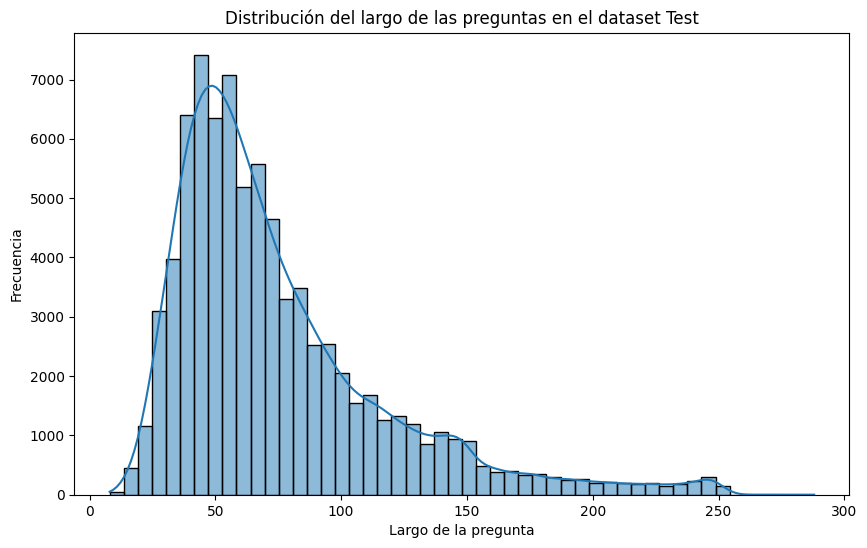

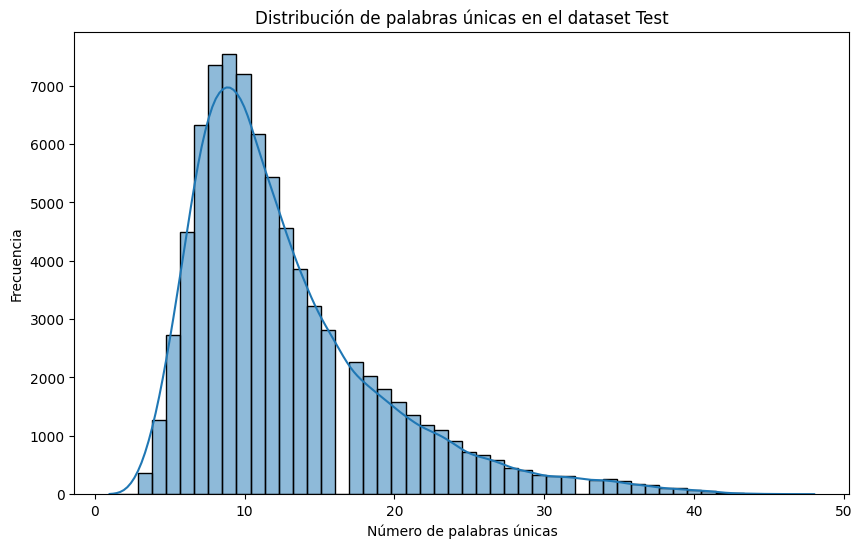


Valores nulos en el dataset Test:
question_text    0
target           0
length           0
unique_words     0
dtype: int64


In [6]:
for name, dataset in datasets.items():
    print(f"\nInformación básica del dataset {name}:")
    print(dataset.info())
    print(f"\nPrimeras 5 filas del dataset {name}:")
    print(dataset.head())

    # Distribución de las clases en el dataset
    if 'target' in dataset.columns:
        plt.figure(figsize=(6, 4))
        sns.countplot(x='target', data=dataset)
        plt.title(f'Distribución de clases en el dataset {name}')
        plt.xlabel('Clase (0: Sinceras, 1: Insinceras)')
        plt.ylabel('Cantidad')
        plt.show()

    # Análisis del largo de las preguntas
    dataset['length'] = dataset['question_text'].apply(len)
    plt.figure(figsize=(10, 6))
    sns.histplot(dataset['length'], bins=50, kde=True)
    plt.title(f'Distribución del largo de las preguntas en el dataset {name}')
    plt.xlabel('Largo de la pregunta')
    plt.ylabel('Frecuencia')
    plt.show()

    # Distribución de palabras únicas
    dataset['unique_words'] = dataset['question_text'].apply(lambda x: len(set(str(x).split())))
    plt.figure(figsize=(10, 6))
    sns.histplot(dataset['unique_words'], bins=50, kde=True)
    plt.title(f'Distribución de palabras únicas en el dataset {name}')
    plt.xlabel('Número de palabras únicas')
    plt.ylabel('Frecuencia')
    plt.show()

    # Verificando valores nulos
    print(f"\nValores nulos en el dataset {name}:")
    print(dataset.isnull().sum())

Las distribuciones entre training, validation y test son muy similares lo cual es un buen indicio.

## Analisis Exploratorio mas avanzado

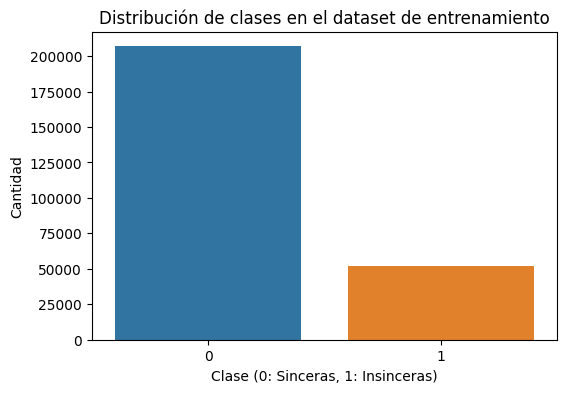

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

# 1. Distribución de clases
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=train)
plt.title('Distribución de clases en el dataset de entrenamiento')
plt.xlabel('Clase (0: Sinceras, 1: Insinceras)')
plt.ylabel('Cantidad')
plt.show()

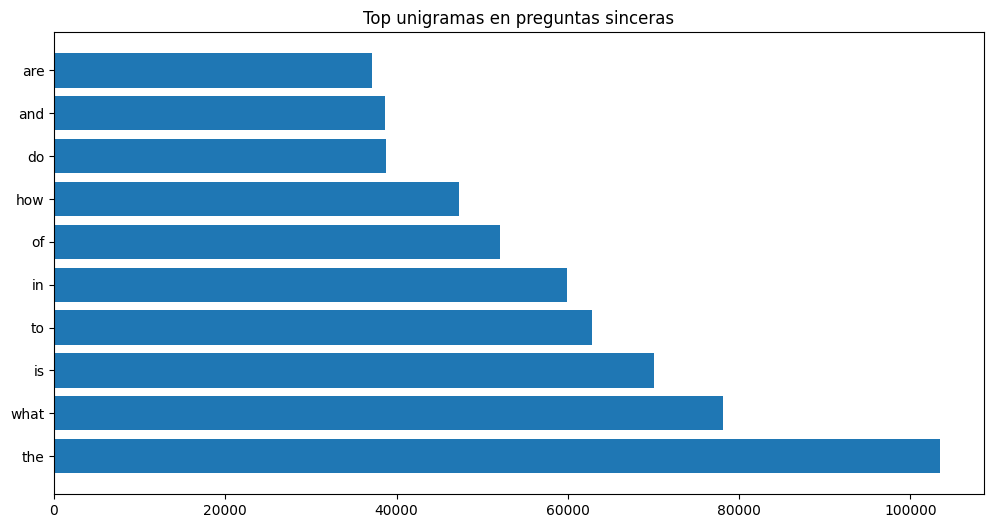

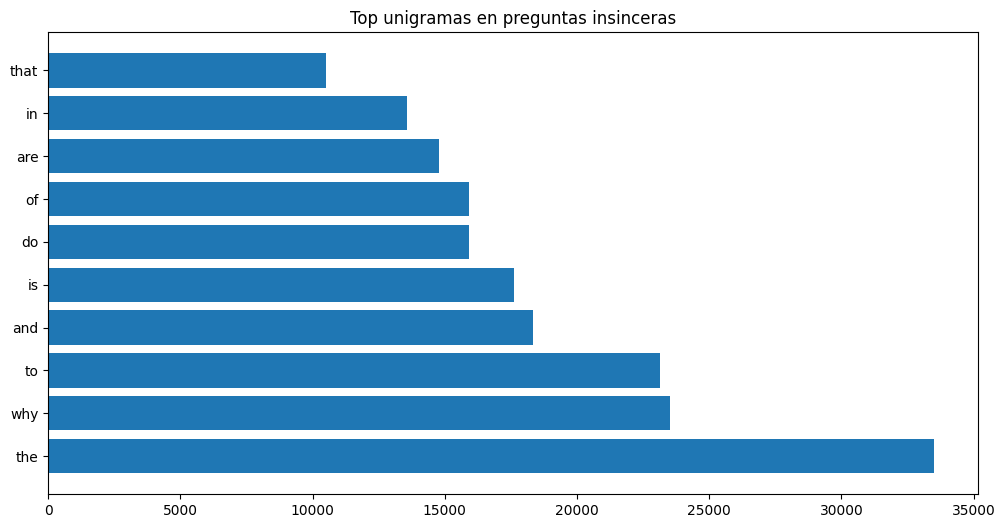

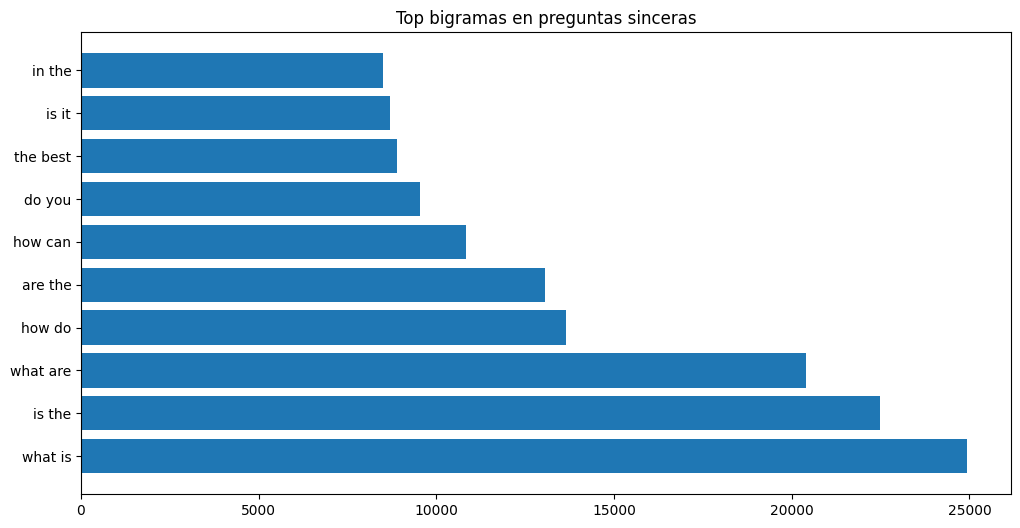

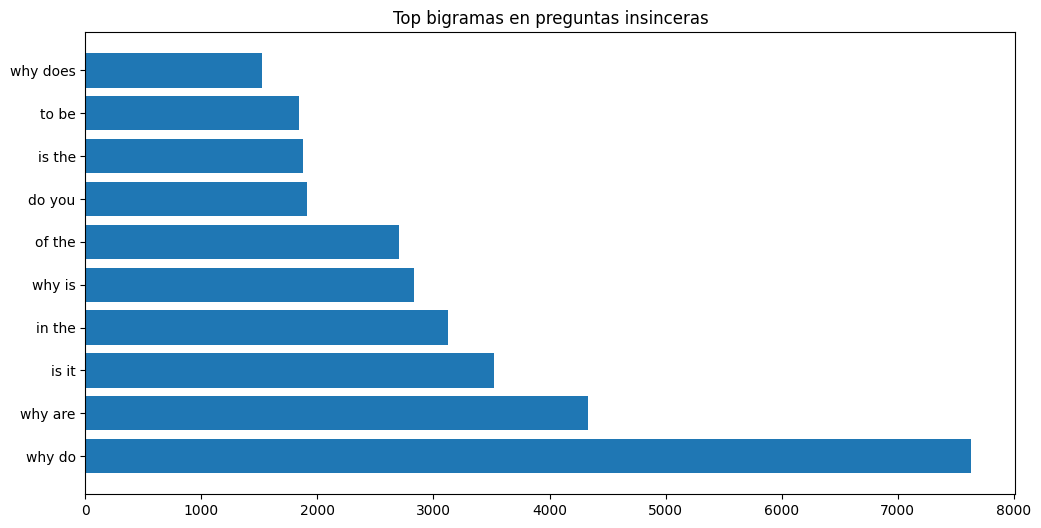

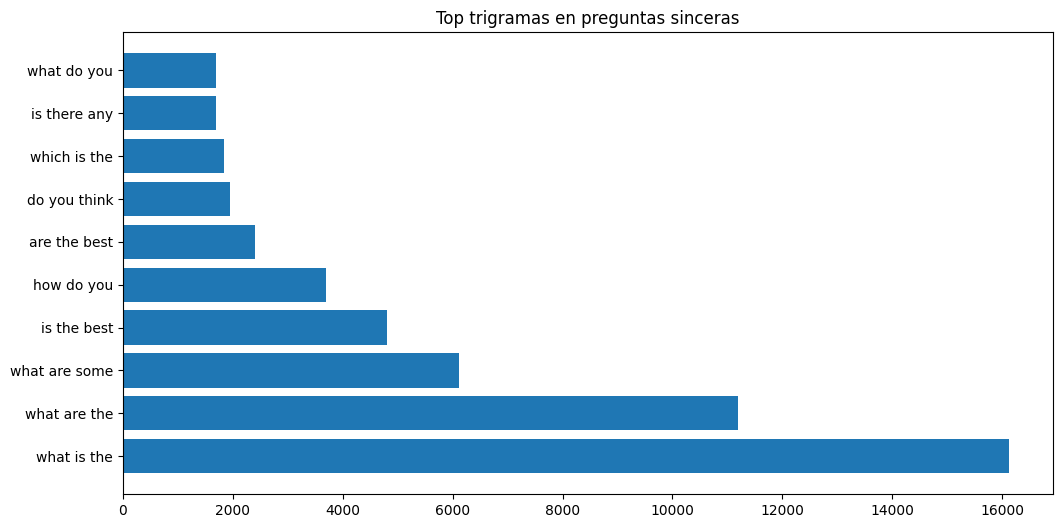

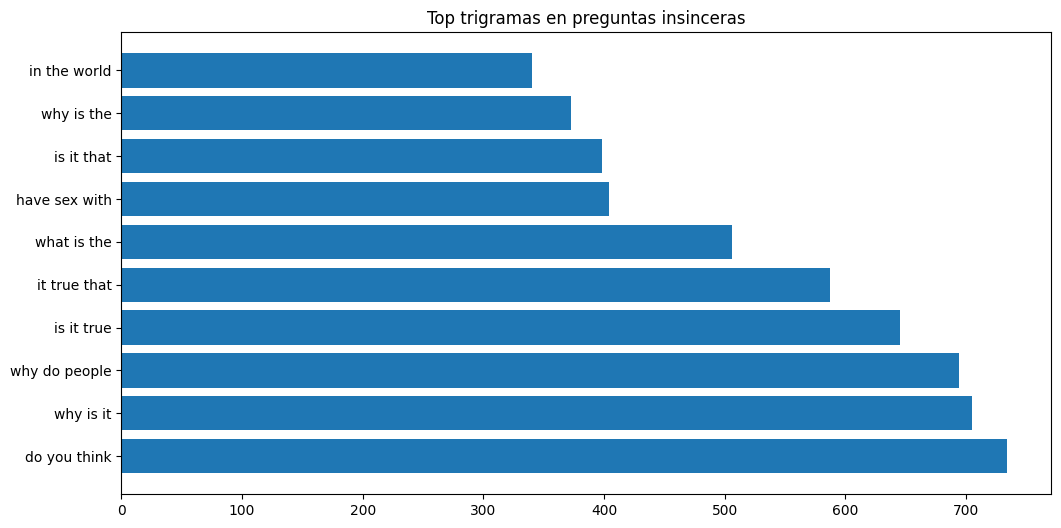

In [8]:
# 2. Análisis de n-gramas
def plot_top_ngrams(data, ngram_range=(1,1), top=10, title=""):
    # Función para plotear los n-gramas más comunes
    vec = CountVectorizer(ngram_range=ngram_range).fit(data)
    bag_of_words = vec.transform(data)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    words, values = zip(*words_freq[:top])
    plt.figure(figsize=(12, 6))
    plt.barh(words, values)
    plt.title(title)
    plt.show()

plot_top_ngrams(train[train['target']==0]['question_text'], (1,1), title="Top unigramas en preguntas sinceras")
plot_top_ngrams(train[train['target']==1]['question_text'], (1,1), title="Top unigramas en preguntas insinceras")
plot_top_ngrams(train[train['target']==0]['question_text'], (2,2), title="Top bigramas en preguntas sinceras")
plot_top_ngrams(train[train['target']==1]['question_text'], (2,2), title="Top bigramas en preguntas insinceras")
plot_top_ngrams(train[train['target']==0]['question_text'], (3,3), title="Top trigramas en preguntas sinceras")
plot_top_ngrams(train[train['target']==1]['question_text'], (3,3), title="Top trigramas en preguntas insinceras")

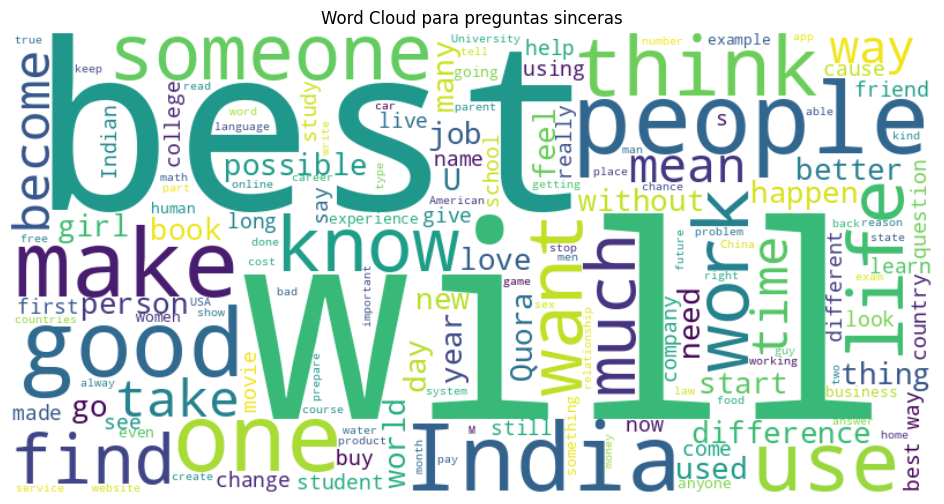

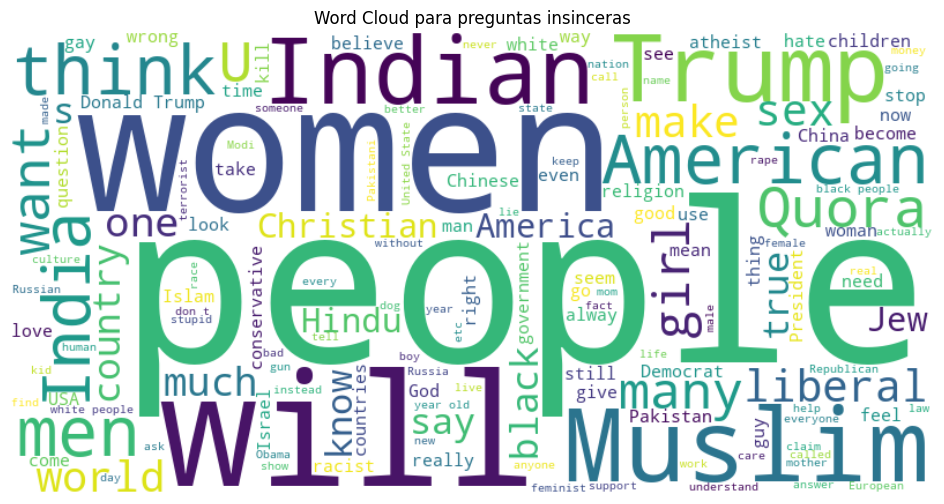

In [9]:
# 3. Word Clouds
def plot_wordcloud(data, title=""):
    # Función para plotear una nube de palabras
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=150).generate(" ".join(data))
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

plot_wordcloud(train[train['target']==0]['question_text'], "Word Cloud para preguntas sinceras")
plot_wordcloud(train[train['target']==1]['question_text'], "Word Cloud para preguntas insinceras")




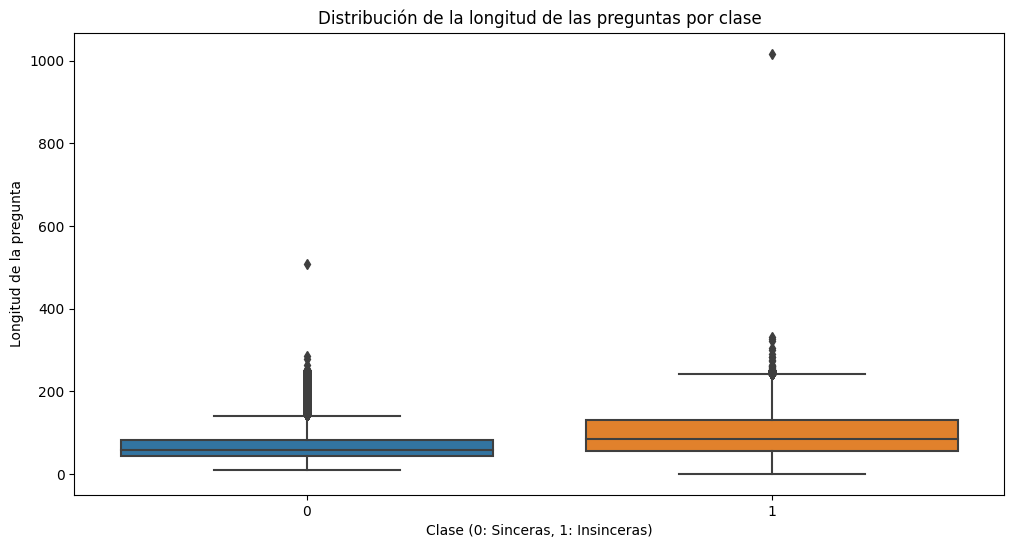

In [10]:
# 4. Boxplots para la longitud de las preguntas
plt.figure(figsize=(12, 6))
sns.boxplot(x='target', y='length', data=train)
plt.title('Distribución de la longitud de las preguntas por clase')
plt.xlabel('Clase (0: Sinceras, 1: Insinceras)')
plt.ylabel('Longitud de la pregunta')
plt.show()


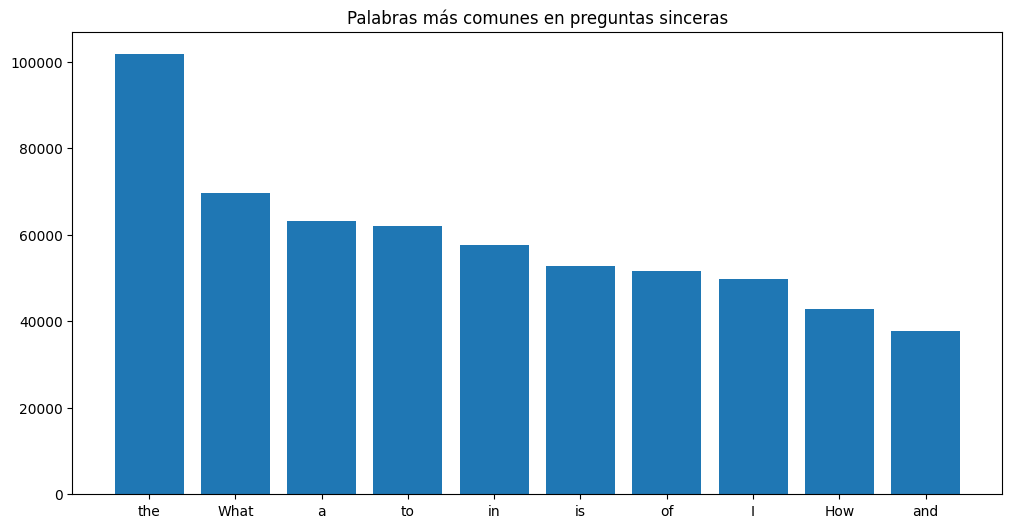

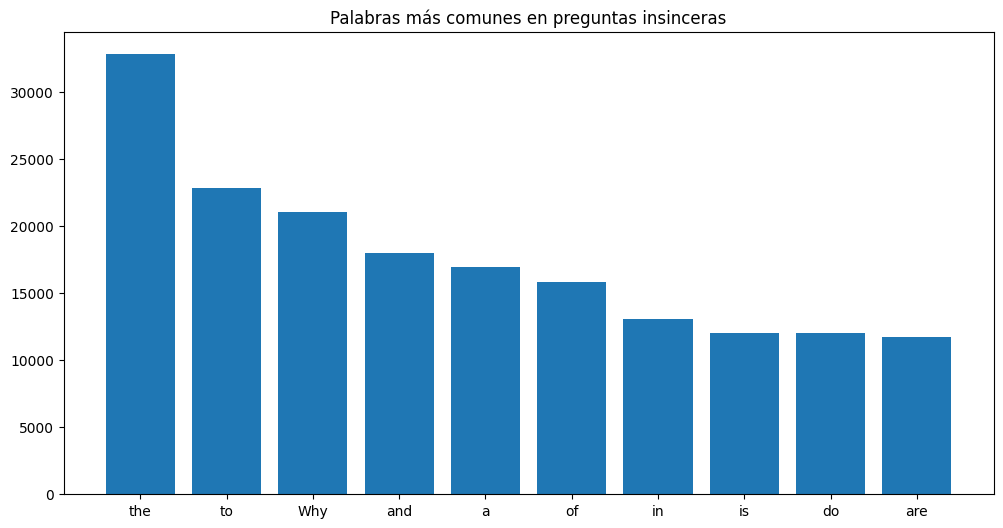

In [11]:
# 5. Palabras más comunes en preguntas sinceras vs insinceras
def plot_most_common_words(data, target_value, title=""):
    # Función para plotear las palabras más comunes
    words = ' '.join(data[data['target']==target_value]['question_text']).split()
    counter = Counter(words)
    most_common = counter.most_common(10)
    words, counts = zip(*most_common)
    plt.figure(figsize=(12, 6))
    # sns.barplot(x = words,y = counts)
    plt.bar(words, counts)

    plt.title(title)
    plt.show()

plot_most_common_words(train, 0, "Palabras más comunes en preguntas sinceras")
plot_most_common_words(train, 1, "Palabras más comunes en preguntas insinceras")

## Removiendo stop words
Voy a remover stop words y volver analizar el set de testing

In [24]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


# Descargar el conjunto de stopwords
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

# Función para eliminar stopwords de un texto
def remove_stopwords(text):
  tokens = word_tokenize(text.lower())  # Primero tokenizo, hago minusculas y despues borro stopwords
  return " ".join([word for word in tokens if word not in stop_words])

# Aplicar la función al dataset
train['question_text'] = train['question_text'].apply(lambda x: remove_stopwords(x))
validation['question_text'] = validation['question_text'].apply(lambda x: remove_stopwords(x))
test['question_text'] = test['question_text'].apply(lambda x: remove_stopwords(x))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


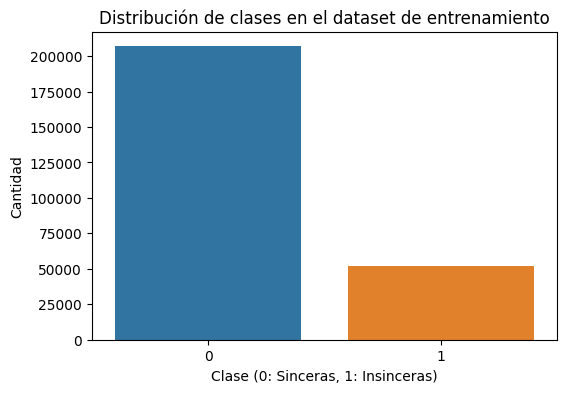

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

# 1. Distribución de clases
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=train)
plt.title('Distribución de clases en el dataset de entrenamiento')
plt.xlabel('Clase (0: Sinceras, 1: Insinceras)')
plt.ylabel('Cantidad')
plt.show()

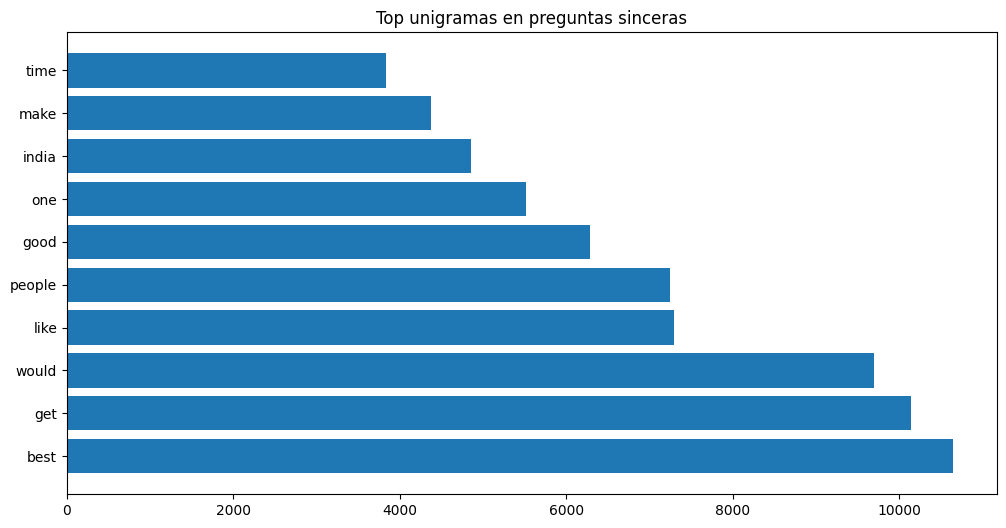

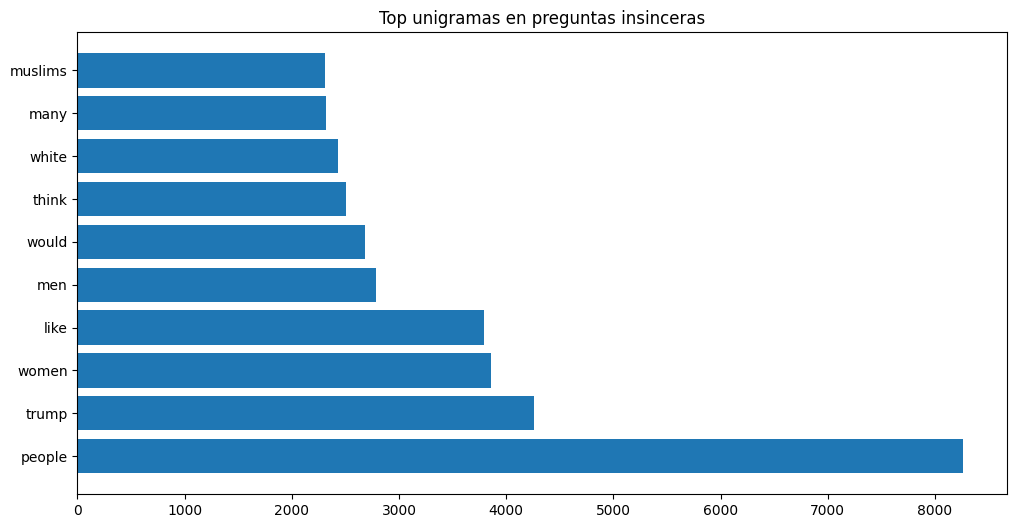

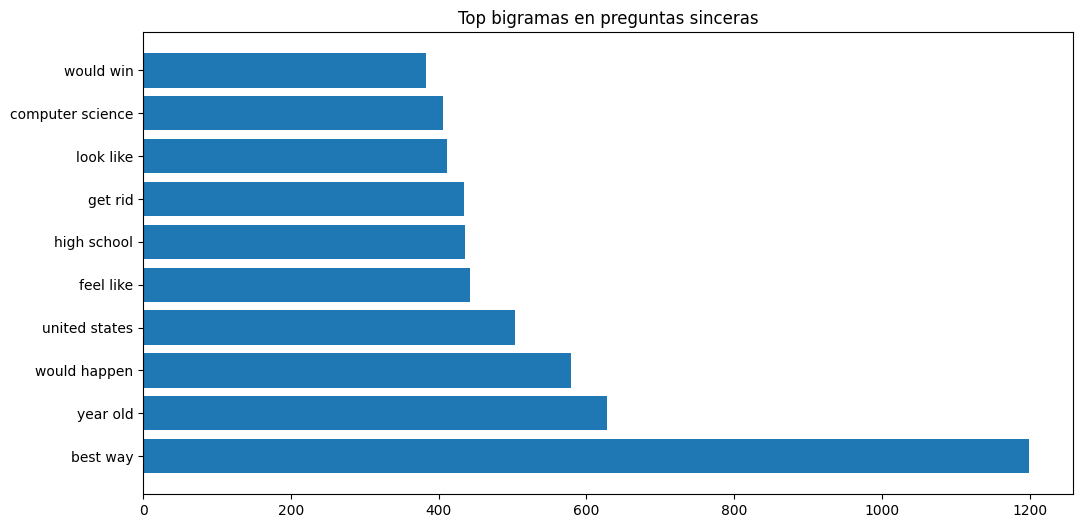

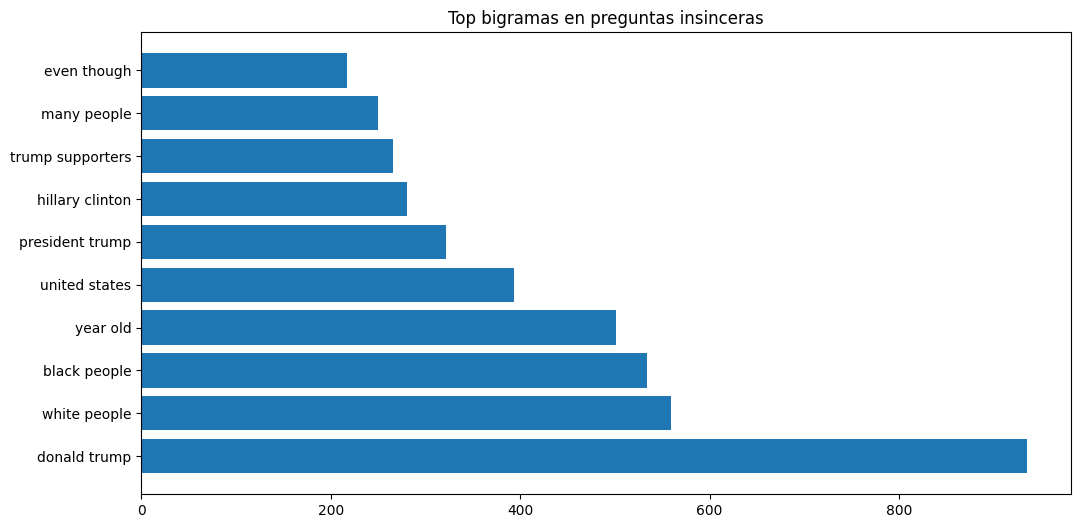

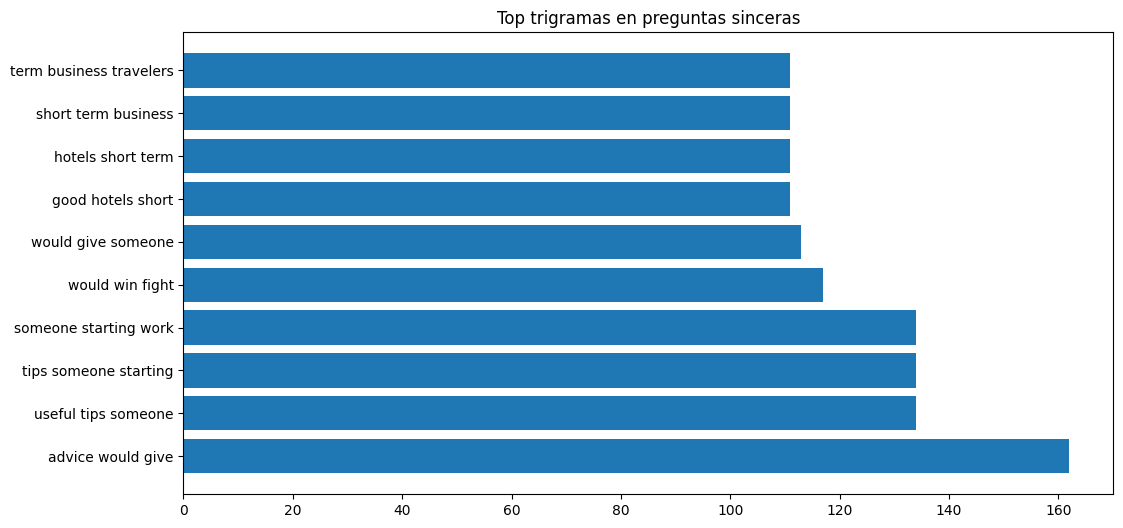

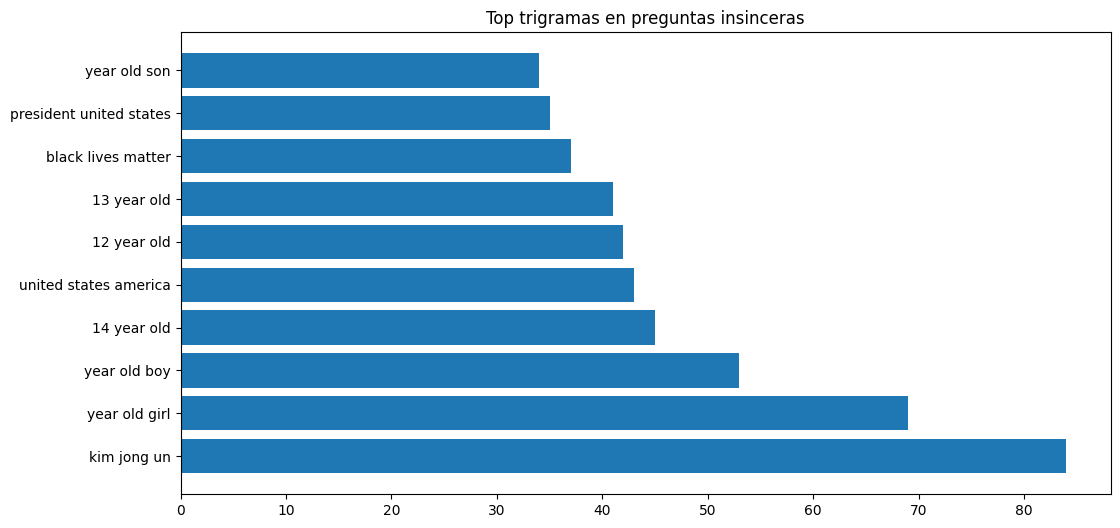

In [27]:
# 2. Análisis de n-gramas
def plot_top_ngrams(data, ngram_range=(1,1), top=10, title=""):
    # Función para plotear los n-gramas más comunes
    vec = CountVectorizer(ngram_range=ngram_range).fit(data)
    bag_of_words = vec.transform(data)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    words, values = zip(*words_freq[:top])
    plt.figure(figsize=(12, 6))
    plt.barh(words, values)
    plt.title(title)
    plt.show()

plot_top_ngrams(train[train['target']==0]['question_text'], (1,1), title="Top unigramas en preguntas sinceras")
plot_top_ngrams(train[train['target']==1]['question_text'], (1,1), title="Top unigramas en preguntas insinceras")
plot_top_ngrams(train[train['target']==0]['question_text'], (2,2), title="Top bigramas en preguntas sinceras")
plot_top_ngrams(train[train['target']==1]['question_text'], (2,2), title="Top bigramas en preguntas insinceras")
plot_top_ngrams(train[train['target']==0]['question_text'], (3,3), title="Top trigramas en preguntas sinceras")
plot_top_ngrams(train[train['target']==1]['question_text'], (3,3), title="Top trigramas en preguntas insinceras")

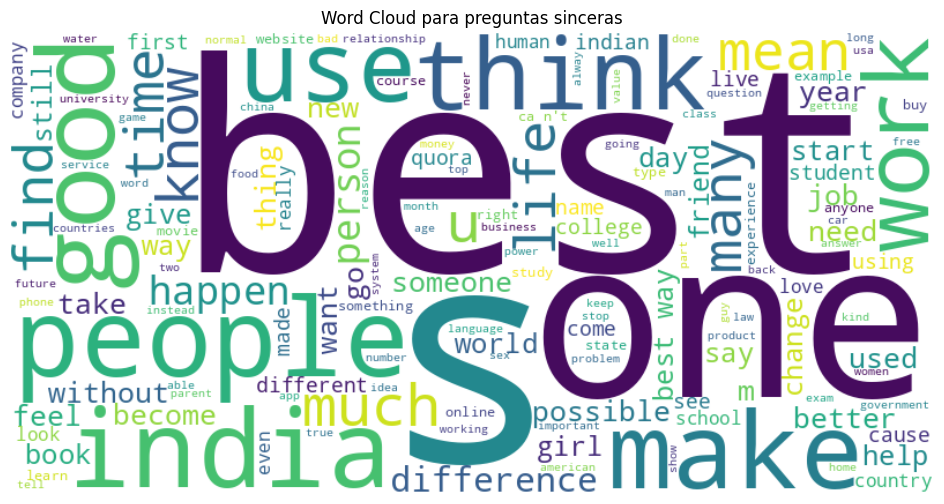

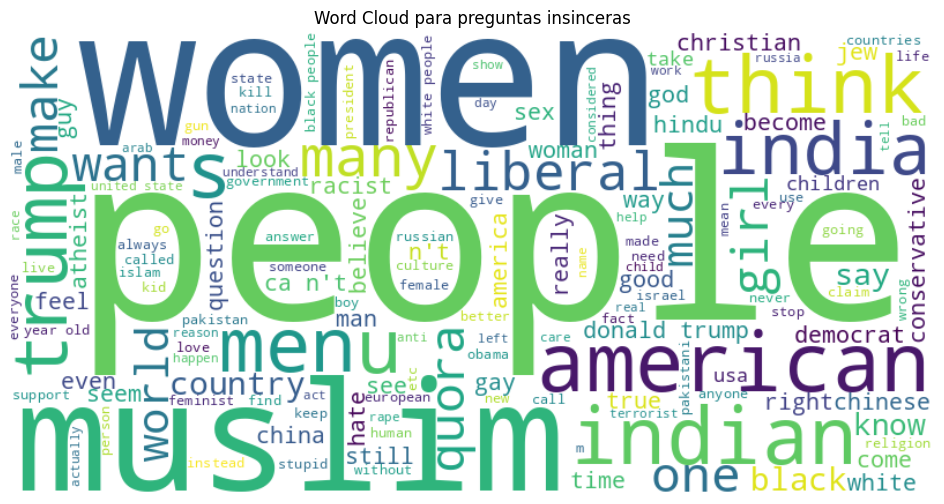

In [28]:
# 3. Word Clouds
def plot_wordcloud(data, title=""):
    # Función para plotear una nube de palabras
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=150).generate(" ".join(data))
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

plot_wordcloud(train[train['target']==0]['question_text'], "Word Cloud para preguntas sinceras")
plot_wordcloud(train[train['target']==1]['question_text'], "Word Cloud para preguntas insinceras")




In [29]:
# 4. Boxplots para la longitud de las preguntas
plt.figure(figsize=(12, 6))
sns.boxplot(x='target', y='length', data=train)
plt.title('Distribución de la longitud de las preguntas por clase')
plt.xlabel('Clase (0: Sinceras, 1: Insinceras)')
plt.ylabel('Longitud de la pregunta')
plt.show()


ValueError: ignored

<Figure size 1200x600 with 0 Axes>

In [ ]:
# 5. Palabras más comunes en preguntas sinceras vs insinceras
def plot_most_common_words(data, target_value, title=""):
    # Función para plotear las palabras más comunes
    words = ' '.join(data[data['target']==target_value]['question_text']).split()
    counter = Counter(words)
    most_common = counter.most_common(10)
    words, counts = zip(*most_common)
    plt.figure(figsize=(12, 6))
    # sns.barplot(x = words,y = counts)
    plt.bar(words, counts)

    plt.title(title)
    plt.show()

plot_most_common_words(train, 0, "Palabras más comunes en preguntas sinceras")
plot_most_common_words(train, 1, "Palabras más comunes en preguntas insinceras")

In [ ]:
# Check if 'why' is a stopword
is_stopword = 'why' in stop_words
print(f"why es una stopword?: {is_stopword}")

# Preprocesamiento

## Cargo datos nuevamente

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
! cp -r "/content/drive/MyDrive/Colab Notebooks/Datasets/insincere_questions/." .
! ls

drive  sample_data  test_set.csv  train_set.csv


In [3]:
import time
import torch
import itertools
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns


In [4]:
# Global device config
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
all_train_data = pd.read_csv("train_set.csv")
train, validation = train_test_split(all_train_data,
stratify=all_train_data.target, test_size=0.2)
print(f"{len(train)} Training questions, {len(validation)} Validation questions")

test = pd.read_csv("test_set.csv")


258592 Training questions, 64648 Validation questions


In [5]:
# Análisis exploratorio básico de los datasets
datasets = {'Training': train, 'Validation': validation, 'Test': test}

## Data Cleaning

In [6]:
import re
import nltk
from nltk.corpus import stopwords

# Descargar stopwords de nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Elimina caracteres especiales y convierte el texto a minúsculas
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    text = text.lower()
    text = text.strip()
    # Elimina stopwords
    tokens = text.split()
    filtered_tokens = [token for token in tokens if token not in stop_words]
    text = ' '.join(filtered_tokens)
    return text

train['question_text'] = train['question_text'].apply(clean_text)
validation['question_text'] = validation['question_text'].apply(clean_text)
test['question_text'] = test['question_text'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Tokenización

In [7]:
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab

# Tokenizar y crear un vocabulario
tokenizer = get_tokenizer('basic_english')
counter = Counter()
for line in train['question_text']:  # Asegúrate de que 'question_text' es la columna correcta
    counter.update(tokenizer(line))
vocab = Vocab(counter)

# Convertir texto a tensor de tokens
text_pipeline = lambda x: [vocab[token] for token in tokenizer(x)]

train_tokenized = [text_pipeline(text) for text in train['question_text']]
val_tokenized = [text_pipeline(text) for text in validation['question_text']]
test_tokenized = [text_pipeline(text) for text in test['question_text']]


## Embeddings

### Glove

In [8]:
from torchtext.vocab import GloVe

# Cargar los embeddings de GloVe (ejemplo para GloVe de 50 dimensiones)
embedding_dim = 300
glove = GloVe(name='6B', dim=embedding_dim)

# 1. Crear el vocabulario
word_to_idx = {word: idx for idx, (word, _) in enumerate(counter.most_common())}

# 2. Crear matriz de embeddings para nuestro vocabulario
embedding_matrix = torch.zeros(len(word_to_idx), embedding_dim)
for word, idx in word_to_idx.items():
    if word in glove.stoi:
        embedding_matrix[idx] = glove[word]



In [9]:
len(train)

258592

In [10]:
embedding_matrix

tensor([[-0.4135,  0.0760,  0.0992,  ...,  0.1595, -0.1322,  0.0309],
        [-0.1412, -0.1184, -0.3078,  ..., -0.1988, -0.0611,  0.1157],
        [-0.1610,  0.3556, -0.5446,  ..., -0.5916, -0.2332,  0.2109],
        ...,
        [-0.1130, -0.3686, -0.1346,  ...,  0.0768,  0.3431, -0.0649],
        [-0.1675, -0.0158,  0.2771,  ..., -0.0472,  0.6666, -0.4280],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [11]:
# 1. Dimensiones de la Matriz
print(f"Expected Shape: {len(word_to_idx), embedding_dim}")
print(f"Actual Shape: {embedding_matrix.shape}")

# 2. Verificar palabras específicas
sample_words = ["king", "queen", "computer"]
for word in sample_words:
    print(f"\nEmbedding for {word}:")
    print(embedding_matrix[word_to_idx[word]])

    # Verificación contra GloVe
    if word in glove.stoi:
        print(f"GloVe Embedding for {word}:")
        print(glove[word])
    else:
        print(f"{word} not in GloVe vocabulary!")

# 3. Valores Cero
zero_rows = torch.sum((embedding_matrix == 0), dim=1) == embedding_dim
print(f"\nNumber of words not in GloVe vocabulary: {zero_rows.sum().item()}")


Expected Shape: (90255, 300)
Actual Shape: torch.Size([90255, 300])

Embedding for king:
tensor([ 0.0034, -0.3461,  0.2814,  0.4838,  0.5947,  0.0130,  0.5398,  0.4823,
         0.2146, -1.0249, -0.3479, -0.7900, -0.1508,  0.6137,  0.0428,  0.1932,
         0.2546,  0.3253,  0.0570,  0.0633, -0.4944,  0.4734, -0.1676,  0.0456,
         0.3045, -0.3542, -0.3458, -0.2012,  0.2551,  0.0911,  0.0147, -0.0175,
        -0.2385,  0.4821, -0.9145, -0.3623,  0.3474,  0.0286, -0.0271, -0.0365,
        -0.0674, -0.2345, -0.1377,  0.3395,  0.1341, -0.1342,  0.4786, -0.1842,
         0.1071, -0.4583, -0.3609, -0.2260,  0.3288, -0.1364,  0.2313,  0.3427,
         0.4234,  0.4706,  0.4790,  0.0746,  0.3344,  0.1071, -0.1329,  0.5873,
         0.3862, -0.5224, -0.2203, -0.0723,  0.3227,  0.4423, -0.0374,  0.1832,
         0.0581,  0.2694,  0.3620,  0.1398,  0.0168, -0.3443,  0.4827,  0.2108,
         0.7562, -0.1309, -0.0257,  0.4339,  0.3389, -0.1644,  0.2682,  0.6877,
         0.3110, -0.2509,  0.00

### FastText

In [12]:
from torchtext.vocab import FastText

# Cargar los embeddings de FastText (ejemplo para FastText en inglés)
fasttext = FastText(language="en")

# Definir la dimensión para FastText
embedding_dim_fasttext = 300

# Crear matriz de embeddings para FastText
embedding_matrix_fasttext = torch.zeros(len(word_to_idx), embedding_dim_fasttext)
for word, idx in word_to_idx.items():
    if word in fasttext.stoi:
        embedding_matrix_fasttext[idx] = fasttext[word]

# Verificar para palabras específicas
for word in sample_words:
    print(f"\nFastText Embedding for {word}:")
    print(embedding_matrix_fasttext[word_to_idx[word]])



FastText Embedding for king:
tensor([ 0.0326, -0.1816, -0.2905, -0.1051, -0.1671, -0.0775, -0.5661, -0.0862,
        -0.0022,  0.1537,  0.1219, -0.1472,  0.0151,  0.0721, -0.0216, -0.2061,
        -0.0210, -0.0200, -0.1551,  0.0080, -0.2275,  0.3352, -0.1063, -0.5032,
        -0.1582,  0.2783,  0.0575, -0.3270,  0.0477,  0.0108,  0.1397, -0.1244,
        -0.1899,  0.3297, -0.3251,  0.1096,  0.2196, -0.4721,  0.0342, -0.2207,
         0.0218,  0.0832, -0.0478, -0.4887,  0.0521, -0.1500, -0.1920,  0.0618,
         0.1553, -0.0560,  0.1107,  0.3916, -0.1772,  0.0545,  0.2590, -0.1395,
         0.4272, -0.0727, -0.4714,  0.0499,  0.2953, -0.0532,  0.0345, -0.1058,
        -0.3014,  0.1637,  0.0754,  0.2102, -0.1146,  0.1098,  0.0492,  0.1769,
         0.4566, -0.5976, -0.0039,  0.0887,  0.5310,  0.1530, -0.1673,  0.1312,
        -0.0555, -0.0358, -0.3453,  0.0913,  0.0332,  0.4521, -0.1689,  0.2114,
         0.2415,  0.5101, -0.0147, -0.4718,  0.2235, -0.3467,  0.1213,  0.2373,
        -0

### Word2Vec

In [14]:
import requests
import zipfile
import os

# URL del archivo ZIP
url = "http://vectors.nlpl.eu/repository/20/40.zip"

# Descargar el archivo ZIP
response = requests.get(url, stream=True)
filename = "word2vec.zip"
with open(filename, 'wb') as f:
    for chunk in response.iter_content(chunk_size=8192):
        f.write(chunk)

# Descomprimir el archivo ZIP
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall("word2vec_folder")

# La ruta al archivo descomprimido debería ser algo como
word2vec_path = os.path.join("word2vec_folder", "model.bin")

print(f"Word2Vec file is located at: {word2vec_path}")



Word2Vec file is located at: word2vec_folder/model.bin


In [15]:
from gensim.models import KeyedVectors

# Cargar el modelo Word2Vec
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

# Obtener la dimensión de los embeddings (generalmente es 300 para Word2Vec)
embedding_dim_w2v = word2vec.vector_size

# Inicializar la matriz de embeddings con ceros
embedding_matrix_w2v = torch.zeros(len(word_to_idx), embedding_dim_w2v)

# Llenar la matriz de embeddings
for word, idx in word_to_idx.items():
    if word in word2vec:
        embedding_matrix_w2v[idx] = torch.tensor(word2vec[word])

# Verificar para algunas palabras específicas
sample_words = ["king", "queen", "computer"]
for word in sample_words:
    print(f"\nWord2Vec Embedding for {word}:")
    print(embedding_matrix_w2v[word_to_idx[word]])



NameError: ignored

### King - men + woman = ?

In [15]:
result = word2vec.most_similar(positive=['king', 'woman'], negative=['man'], topn=1)
print(f"king - man + woman = {result[0][0]} with similarity score of {result[0][1]}")


king - man + woman = queen with similarity score of 0.8487650752067566


Implemento similaridad del coseno para encontrar los vectores mas similares:

In [16]:
import torch.nn.functional as F

def cosine_similarity(vec_a, vec_b):
    return F.cosine_similarity(vec_a.unsqueeze(0), vec_b.unsqueeze(0)).item()

In [17]:
def find_analogy(embedding, word1, word2, word3, topn=1):
    """Encuentra la palabra resultante de la analogía word1 - word2 + word3 usando el embedding proporcionado."""
    if word1 not in embedding.stoi or word2 not in embedding.stoi or word3 not in embedding.stoi:
        raise ValueError("Al menos una de las palabras no está en el vocabulario del embedding.")

    # Realizar la operación vectorial
    result_vector = embedding[word1] - embedding[word2] + embedding[word3]

    # Calcular la similitud del coseno con todos los vectores y obtener los topn más similares
    similarities = [(word, cosine_similarity(result_vector, embedding[word])) for word in embedding.stoi]
    sorted_similarities = sorted(similarities, key=lambda x: x[1], reverse=True)

    # Filtrar las palabras originales
    filtered_similarities = [word for word, sim in sorted_similarities if word not in [word1, word2, word3]]

    return filtered_similarities[:topn]


In [18]:
# Glove
result_glove = find_analogy(glove, 'king', 'man', 'woman', topn=3)
print(f"GloVe (torchtext): king - man + woman = {result_glove[0]}")

#
result_fasttext = find_analogy(glove, 'king', 'man', 'woman', topn=3)
print(f"Fasttext (torchtext): king - man + woman = {result_fasttext[0]}")

GloVe (torchtext): king - man + woman = queen
Fasttext (torchtext): king - man + woman = queen


In [19]:
print(f"Glove - Top 3: {result_glove[:3]}")
print(f"Fasttext - Top 3: {result_fasttext[:3]}")


Glove - Top 3: ['queen', 'monarch', 'throne']
Fasttext - Top 3: ['queen', 'monarch', 'throne']


# Modelo

## Funciones de train, validation and test

In [20]:
def train_epoch(model, iterator, optimizer, criterion):
    model.train()

    epoch_loss = 0
    all_predictions = []
    all_targets = []

    for batch in iterator:
        text = batch[0]
        text_lengths = (text != 0).sum(dim=1)  # Compute lengths based on non-zero tokens

        optimizer.zero_grad()

        predictions = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions, batch[1].float())
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Convertir las predicciones a 0s y 1s
        binary_predictions = torch.round(torch.sigmoid(predictions))
        all_predictions.extend(binary_predictions.cpu().detach().numpy())
        all_targets.extend(batch[1].cpu().numpy())

    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions)
    recall = recall_score(all_targets, all_predictions)
    f1 = f1_score(all_targets, all_predictions)

    return epoch_loss / len(iterator), accuracy, precision, recall, f1

def val_epoch(model, iterator, criterion):
    model.eval()

    epoch_loss = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch in iterator:
            text = batch[0]
            text_lengths = (text != 0).sum(dim=1)  # Compute lengths based on non-zero tokens

            predictions = model(text, text_lengths).squeeze(1)
            loss = criterion(predictions, batch[1].float())

            epoch_loss += loss.item()

            # Convertir las predicciones a 0s y 1s
            binary_predictions = torch.round(torch.sigmoid(predictions))
            all_predictions.extend(binary_predictions.cpu().detach().numpy())
            all_targets.extend(batch[1].cpu().numpy())

    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions)
    recall = recall_score(all_targets, all_predictions)
    f1 = f1_score(all_targets, all_predictions)

    return epoch_loss / len(iterator), accuracy, precision, recall, f1



In [21]:
def train_model(model, train_iterator, val_iterator, optimizer, criterion, epochs):
    for epoch in range(epochs):
        train_loss, train_acc, train_prec, train_recall, train_f1 = train_epoch(model, train_iterator, optimizer, criterion)
        val_loss, val_acc, val_prec, val_recall, val_f1 = val_epoch(model, val_iterator, criterion)

        print(f"Epoch: {epoch+1:02}")
        print(f"\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Train Prec: {train_prec:.3f} | Train Recall: {train_recall:.3f} | Train F1: {train_f1:.3f}")
        print(f"\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}% | Val. Prec: {val_prec:.3f} | Val. Recall: {val_recall:.3f} | Val. F1: {val_f1:.3f}")


In [22]:
def test_model(model, test_iterator, criterion):
    test_loss, test_acc, test_prec, test_recall, test_f1 = val_epoch(model, test_iterator, criterion)

    print(f"Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Test Prec: {test_prec:.3f} | Test Recall: {test_recall:.3f} | Test F1: {test_f1:.3f}")


## LSTM

In [97]:
import re
import nltk
from nltk.corpus import stopwords
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import vocab

# Descargar stopwords de nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Elimina caracteres especiales y convierte el texto a minúsculas
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    text = text.lower()
    text = text.strip()
    # Elimina stopwords
    tokens = text.split()
    filtered_tokens = [token for token in tokens if token not in stop_words]
    return filtered_tokens

# Tokenizar y crear un vocabulario
tokenizer = get_tokenizer('basic_english')
counter = Counter()
for line in train['question_text']:  # Asegúrate de que 'question_text' es la columna correcta
    counter.update(tokenizer(line))
vocab = vocab(counter)

# Convertir texto a tensor de tokens
text_pipeline = lambda x: [vocab[token] for token in tokenizer(x)]

stoi_mapping = vocab.get_stoi()

def get_sentence_embedding(sentence, embedding_type='word2vec'):
    tokens = clean_text(sentence)

    embeddings_list = []
    if embedding_type == 'word2vec':
        embeddings_list = [word2vec.get_vector(token) for token in tokens if token in word2vec.key_to_index]
    elif embedding_type == 'glove':
        embeddings_list = [glove.get_vector(token) for token in tokens if token in glove.key_to_index]
    elif embedding_type == 'fasttext':
        embeddings_list = [fasttext.get_vector(token) for token in tokens if token in fasttext.key_to_index]

    if not embeddings_list:
        if embedding_type == 'word2vec':
            return np.zeros((100,))
        elif embedding_type == 'glove' or embedding_type == 'fasttext':
            return np.zeros((300,))

    # Compute the mean embedding for the sentence
    return np.mean(embeddings_list, axis=0)
#embeddings_list


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [113]:
from torch.utils.data import DataLoader, TensorDataset

EMBEDDING_TYPE = 'word2vec'
BATCH_SIZE = 64

def prepare_data(dataset, text_column, target_column, embedding_type):
    # Generate sentence embeddings
    vectors = [get_sentence_embedding(sent, embedding_type) for sent in dataset[text_column]]

    # Filter out None embeddings
    valid_indices = [i for i, vec in enumerate(vectors) if vec is not None]
    vectors = [vectors[i] for i in valid_indices]
    targets = torch.Tensor(dataset[target_column].iloc[valid_indices].to_numpy()).long()

    # Convert list of vectors to tensor
    vectors_tensor = torch.stack([torch.Tensor(vec) for vec in vectors])

    # Boolean mask for non-empty vectors
    non_empty_mask = torch.tensor([len(vec) > 0 for vec in vectors])

    # Use boolean indexing to filter out empty vectors
    vectors_tensor = vectors_tensor[non_empty_mask]
    targets_tensor = targets[non_empty_mask]

    # Create dataloader
    dataset_tensor = TensorDataset(vectors_tensor, targets_tensor)
    dataloader = DataLoader(dataset_tensor, batch_size=BATCH_SIZE, pin_memory=True, num_workers=2)

    return dataloader

# Using the function to create dataloaders
train_dataloader = prepare_data(train, 'question_text', 'target', EMBEDDING_TYPE)
val_dataloader = prepare_data(validation, 'question_text', 'target', EMBEDDING_TYPE)
test_dataloader = prepare_data(test, 'question_text', 'target', EMBEDDING_TYPE)




In [117]:
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim, num_layers, dropout):
        super(LSTMClassifier, self).__init__()

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)

        self.lstm = nn.LSTM(input_size=embedding_matrix.shape[1],
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout if num_layers > 1 else 0)

        self.fc = nn.Linear(hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True, enforce_sorted=False)

        packed_output, (hidden, cell) = self.lstm(packed_embedded)

        return self.fc(self.dropout(hidden[-1]))


In [118]:
# Defino el modelo
# 3 embeddings_matrix: Glove = embedding_matrix, word2vec = embedding_matrix_w2v, Fasttext = embedding_matrix_fasttext
# Embedding dim for them = Glove = 300, word2vec = 100, Fasttext = 300

HIDDEN_DIM = 256
OUTPUT_DIM = 1
NUM_LAYERS = 2
DROPOUT = 0.5

model = LSTMClassifier(embedding_matrix=embedding_matrix,
                       hidden_dim=HIDDEN_DIM,
                       output_dim=OUTPUT_DIM,
                       num_layers=NUM_LAYERS,
                       dropout=DROPOUT).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 5
train_model(model, train_dataloader, val_dataloader, optimizer, criterion, epochs)
test_model(model, test_dataloader, criterion)


RuntimeError: ignored

In [ ]:
train['question_text']
lengths = [len(pregunta) for pregunta in train['question_text']]
lengths[lengths==0]

## Nuevo enfoque LSTM

In [8]:
import spacy
from collections import Counter
from torchtext.vocab import Vocab

# Use spaCy for tokenization
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser", "ner"])

def tokenize(text):
    return [tok.text for tok in nlp(text)]

def tokenize_batch(texts):
    return [[tok.text for tok in doc] for doc in nlp.pipe(texts, batch_size=1000)]


In [9]:
counter = Counter()
# for text in train['question_text']:
#     counter.update(tokenize(text))

for tokenized_text in tokenize_batch(train['question_text']):
    counter.update(tokenized_text)

# Tokenize all texts and create a vocabulary
from torchtext.vocab import vocab


# Create a vocabulary object
vocab = vocab(counter, min_freq=1)

# Convert text to sequences of indices
def text_to_indices(text):
    return [vocab[token] for token in tokenize(text)]

train_indices = [text_to_indices(text) for text in train['question_text']]

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [13]:
def load_embeddings_for_vocab(vocab, embedding_type='word2vec'):
    embeddings_dict = {}

    for i, word in enumerate(vocab.get_itos()):
        if embedding_type == 'word2vec':
            if word in word2vec.key_to_index:
                embeddings_dict[word] = word2vec.get_vector(word)
        elif embedding_type == 'glove':
            if word in glove.key_to_index:
                embeddings_dict[word] = glove.get_vector(word)
        elif embedding_type == 'fasttext':
            if word in fasttext.key_to_index:
                embeddings_dict[word] = fasttext.get_vector(word)
    return embeddings_dict


word_to_embedding = load_embeddings_for_vocab(vocab, 'word2vec')
embedding_dim = len(next(iter(word_to_embedding.values())))


# Create an embedding matrix
embedding_matrix = torch.randn(len(vocab), embedding_dim)
for i, word in enumerate(vocab.get_itos()):
    if word in word_to_embedding:
        embedding_matrix[i] = torch.Tensor(word_to_embedding[word])


import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim, num_layers, dropout):
        super(LSTMClassifier, self).__init__()

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)

        self.lstm = nn.LSTM(input_size=embedding_matrix.shape[1],
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout if num_layers > 1 else 0)

        self.fc = nn.Linear(hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True, enforce_sorted=False)

        packed_output, (hidden, cell) = self.lstm(packed_embedded)

        return self.fc(self.dropout(hidden[-1]))

model = LSTMClassifier(embedding_matrix, hidden_dim=256, output_dim=1, num_layers=2, dropout=0.5)

NameError: ignored